### GDP pro capita and life expectancy
by Danilo Pierpaoli, 20 September 2022.

How much average net income of a country affect the life expectancy of its inhabitants? It can be argued that a higher average amount of avaialble resources grants opportunity for access to better healthcare, nutrition quality, education, hygene and overall quality of life. If so, in which amount the life expectancy is increased for higher GDP Pro capite countries? Is a linear relationship or does it have diminishing returns (i.e. up to a certain point, extra net income won't affect life expectancy).

The following analysis tries to answer these questions using 2020 and 2010 datasets from WorldBank.

# Getting the data

Four datasets of the World Bank are considered. Two of them , available at https://data.worldbank.org/indicator/NY.GDP.PCAP.CD, lists the GDP Pro Capite (PPP) of the world's countries in current US dollars, for various years. The other datasets, available at http://data.worldbank.org/indicator/SP.DYN.LE00.IN, lists the life expectancy of the world's countries. These datasets are updated and run directly from this notebook connecting 
to the World Bank database.

In [1]:
# Import relevant modules and functions that will be used
from numpy import *
from pandas import *
from pandas_datareader import wb
from scipy.stats import spearmanr
%matplotlib inline

# Declaring variables and indicators used to load the datasets from World Bank
year1 = 2010
year2 = 2020
ppp_indicator = 'NY.GDP.PCAP.CD'
life_indicator = 'SP.DYN.LE00.IN'

#Load the four datasets

ppp_2010 = wb.download(country = 'all',indicator = ppp_indicator, start = year1,end = year1)
ppp_2020 = wb.download(country = 'all',indicator = ppp_indicator, start = year2,end = year2)
life_2010 = wb.download(country = 'all',indicator = life_indicator, start = year1,end = year1)
life_2020 = wb.download(country = 'all',indicator = life_indicator, start = year2,end = year2)

# Cleaning the data

Inspecting the data with head() and tail() shows that:

- the first 49 rows for both the 2010 and 2020 datasets are aggregated data, mainly country groups used by the World Bank, which are not needed for the purpose of this analysis;
- There are plenty of values that are missing for some countries within the four datasets. We are handling it by removing them. We can observe that different datasets have different null values for different coutries.
We are interested to drop the rows with null values for each datasets, as the inner join won't consider the countries that had been removed from one dataset.


In [2]:
ppp_2010 = ppp_2010[49:]
ppp_2010.head()

,,NY.GDP.PCAP.CD
country,year,
Afghanistan,2010,543.306526
Albania,2010,4094.348386
Algeria,2010,4480.786318
American Samoa,2010,10216.817631
Andorra,2010,40849.761277


In [3]:
life_2010= life_2010[49:]
life_2010.head()

,,SP.DYN.LE00.IN
country,year,
Afghanistan,2010,61.028
Albania,2010,76.562
Algeria,2010,74.938
American Samoa,2010,NaN
Andorra,2010,NaN


In [4]:
ppp_2020 = ppp_2020[49:]
life_2020 = life_2020[49:]

In [5]:
#Now we need to reset the index so country is not an index any longer
ppp_2010 = ppp_2010.reset_index()
ppp_2020 = ppp_2020.reset_index()
life_2010 = life_2010.reset_index()
life_2020 = life_2020.reset_index()

In [6]:
#Now we create a function to find the number and identify missing values
def find_null_values(dataframe, column):
    null_row =[]
    count = 0
    while count < len(dataframe):
        if dataframe[column].isnull()[count] == True:
            null_row.append((count,dataframe['country'][count]))
        count +=1    
    return null_row


In [7]:
#Now we run the function to find missing values in the four dataframes:
null_ppp_2010 = find_null_values(ppp_2010,'NY.GDP.PCAP.CD')
null_ppp_2020 = find_null_values(ppp_2020,'NY.GDP.PCAP.CD')
null_life_2010 = find_null_values(life_2010,'SP.DYN.LE00.IN')
null_life_2020 = find_null_values(life_2010,'SP.DYN.LE00.IN')
print(f'Missing values within ppp 2010 dataset    {null_ppp_2010}')
print(f'Missing values within life 2010 dataset:{null_life_2010}')
print(f'Missing values within ppp 2020 dataset:{null_ppp_2020}')   
print(f'Missing values within life 2020 dataset:{null_life_2020}')      

Missing values within ppp 2010 dataset    [(27, 'British Virgin Islands'), (39, 'Channel Islands'), (50, 'Curacao'), (69, 'French Polynesia'), (75, 'Gibraltar'), (103, "Korea, Dem. People's Rep."), (172, 'Sint Maarten (Dutch part)'), (176, 'Somalia'), (183, 'St. Martin (French part)')]
Missing values within life 2010 dataset:[(3, 'American Samoa'), (4, 'Andorra'), (27, 'British Virgin Islands'), (50, 'Curacao'), (55, 'Dominica'), (75, 'Gibraltar'), (94, 'Isle of Man'), (124, 'Marshall Islands'), (130, 'Monaco'), (137, 'Nauru'), (146, 'Northern Mariana Islands'), (150, 'Palau'), (164, 'San Marino'), (172, 'Sint Maarten (Dutch part)'), (181, 'St. Kitts and Nevis'), (200, 'Turks and Caicos Islands'), (201, 'Tuvalu')]
Missing values within ppp 2020 dataset:[(27, 'British Virgin Islands'), (39, 'Channel Islands'), (61, 'Eritrea'), (75, 'Gibraltar'), (94, 'Isle of Man'), (103, "Korea, Dem. People's Rep."), (114, 'Liechtenstein'), (146, 'Northern Mariana Islands'), (172, 'Sint Maarten (Dutch 

In [8]:
#Dropping null values
ppp_2010 = ppp_2010.dropna()
ppp_2020 = ppp_2020.dropna()
life_2010 = life_2010.dropna()
life_2020 = life_2020.dropna()



# Transforming Data

Here we are going to rename the columns and convert currency to the year average local one, GBP in our case, and drop indicator columns. We are going to define a function in order to convert currency.

In [9]:
def usdToGbp2010(value):
    return value * 0.6475 

def usdToGbp2020(value):
    return value * 0.7798

In [10]:
#We can now rename the columns, round and change and add units for the GDP PPP column and life expectancy
gdp_ppp = 'GDP Pro Capita (£)'
life = 'Life Expectancy (years)'
country = 'country'
headings_life = [country,life]
headings_ppp = [country,gdp_ppp]

ppp_2010[gdp_ppp] = ppp_2010[ppp_indicator].apply(usdToGbp2010).apply(round)
ppp_2010 = ppp_2010[headings_ppp]
ppp_2020[gdp_ppp] = ppp_2020[ppp_indicator].apply(usdToGbp2020).apply(round)
ppp_2020 = ppp_2020[headings_ppp]
life_2010[life] = life_2010[life_indicator].apply(round)
life_2010 = life_2010[headings_life]
life_2020[life] = life_2020[life_indicator].apply(round)
life_2020 = life_2020[headings_life]

In [11]:
ppp_2020.head()

,country,GDP Pro Capita (£)
0,Afghanistan,403
1,Albania,4158
2,Algeria,2579
3,American Samoa,10016
4,Andorra,29178


# Combining data

We are now going to combine data using the country as primary key. We will use an inner join, so countries that don't appear in both chosen datasets won't be considered. We will have 2 datasets now we will work with. The merged 2010 and merged 2020 datasets.

In [12]:
pppVSlife2010 = merge(left = ppp_2010,right = life_2010, on = country, how = 'inner')
pppVSlife2020 = merge(left = ppp_2020,right = life_2020, on = country, how = 'inner')
pppVSlife2010.head()

,country,GDP Pro Capita (£),Life Expectancy (years)
0,Afghanistan,352,61
1,Albania,2651,77
2,Algeria,2901,75
3,Angola,2265,55
4,Antigua and Barbuda,8449,76


In [13]:
pppVSlife2020.head()

,country,GDP Pro Capita (£),Life Expectancy (years)
0,Afghanistan,403,65
1,Albania,4158,79
2,Algeria,2579,77
3,Angola,1272,61
4,Antigua and Barbuda,10912,77


# Calculating the correlation


spearman function from scipy module will be used to measure rank correlation between PPP and life expectancy for both tables. The coefficient measured is a number that can have the values between -1 and 1. A correlation of 1 is a perfect direct correlation (you can draw a positive line with the values of each row), a correlation of -1 is a perfect inverse correlation (you can draw a negative line with the values of each row). A perfect correlation doesn't imply any cause-effect relation between the two indicators. We are ignoring the pValue as we are considering the near entirity of world population.

In [14]:
#Storing into series variable the columns we are analyzing:

col_ppp2010 = pppVSlife2010[gdp_ppp]
col_ppp2020 = pppVSlife2020[gdp_ppp]
col_life2010 = pppVSlife2010[life]
col_life2020 = pppVSlife2020[life]

In [15]:
#Now applying spearmanr function for both datasets:

(correlation_2010,pValue1) = spearmanr(col_ppp2010,col_life2010)
(correlation_2020,pValue2) = spearmanr(col_ppp2020,col_life2020)
print(f'The correlation between GDP Pro Capite and Life Expectancy in 2010 is {correlation_2010}')
print(f'The correlation between GDP Pro Capite and Life Expectancy in 2020 is {correlation_2020}')

The correlation between GDP Pro Capite and Life Expectancy in 2010 is 0.8442760610127388
The correlation between GDP Pro Capite and Life Expectancy in 2020 is 0.8571497399096641


We can see that the difference between the two rank correlation is in the order of 0.013. Hence they are quite alike, showing that even with 10 years difference a similar result is expected to show. The correlation is strong but not perfect.

# Visualising Data

We are going to show the visual scatter graph of 2010 dataset. And then for the 2020 dataset. We use logarithmic scale for the second graph

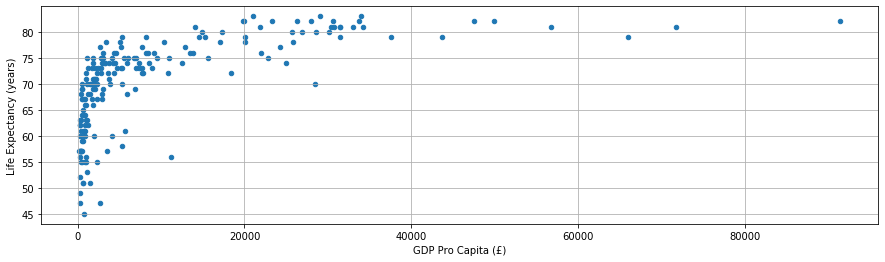

In [16]:
pppVSlife2010.plot(x = gdp_ppp, y = life, kind = 'scatter', grid = True,figsize= (15,4))

The graph is a bit squashed to the y-axis, showing that doesn't take a big increase in PPP to increase significantly life expectancy. We look at logarithmic scale now.

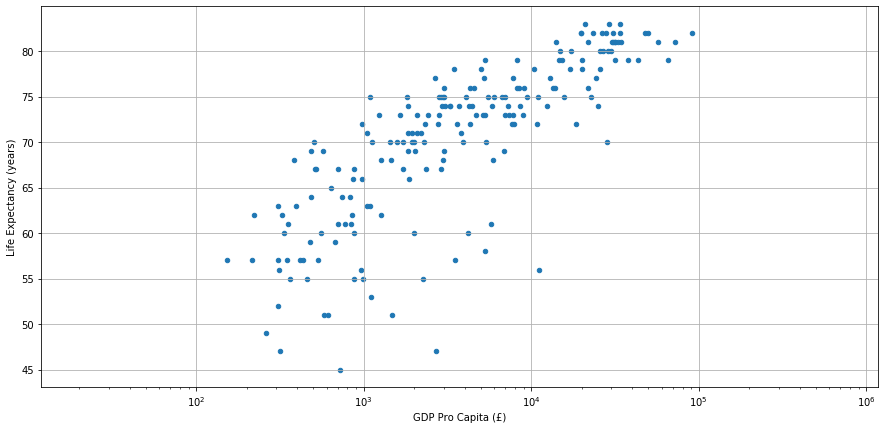

In [17]:
pppVSlife2010.plot(x = gdp_ppp, y = life, kind = 'scatter',logx = True, grid = True,figsize= (15,7))

The same process will be repeated for the 2020 dataset

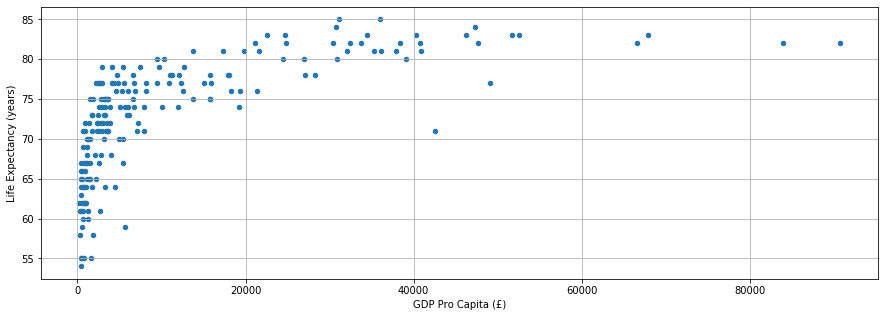

In [18]:
pppVSlife2020.plot(x = gdp_ppp, y = life,grid = True, kind = 'scatter', figsize =(15,5))

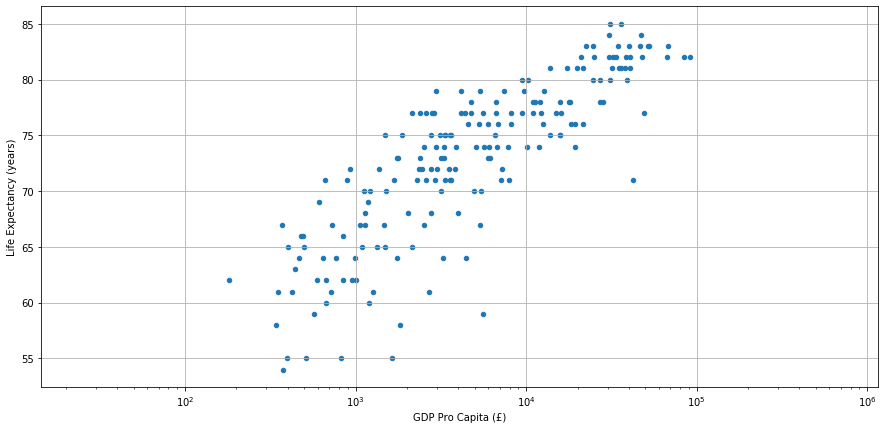

In [19]:
pppVSlife2020.plot(x = gdp_ppp, y = life,grid = True, kind = 'scatter', logx=True,figsize =(15,7))

The last two graphs look very similar in shape to the previous ones. We are going to split up the dataset into high income and low income country to see to which extent the correlation changes

# Further statistical analysis

From the plots emerged a non linear relatioship between the two variable, suggesting life expectancy is affected by GDP Pro Capite in a different way at different values of PPP.

In [20]:
life2010 = pppVSlife2010[life].mean()
life2020 = pppVSlife2020[life].mean()
ppp2010 = pppVSlife2010[gdp_ppp].mean()
ppp2020 = pppVSlife2020[gdp_ppp].mean()
print(f'In 2010 the world average PPP was {ppp2010} and life expectancy {life2010}')
print(f'In 2020 the world average PPP was {ppp2020} and life expectancy {life2020}')

In 2010 the world average PPP was 9679.63076923077 and life expectancy 70.34871794871795
In 2020 the world average PPP was 11720.98947368421 and life expectancy 72.9578947368421


In [21]:
#We need to check pValue here using a function
def pValueCheck(value):
    if value < 0.05:
        print('The correlation is statistically significant')
    else:
        print('The correlation is not statistically significant')
over15000_2010= pppVSlife2010[pppVSlife2010[gdp_ppp]>15000]
over15000_2020 = pppVSlife2020[pppVSlife2020[gdp_ppp] > 15000]

(corr_15000_2010,pValue) = spearmanr(over15000_2010[gdp_ppp],over15000_2010[life])
print(f'The rank correlation between PPP and life expectancy in higher income country for 2010 dataset is {corr_15000_2010}')
pValueCheck(pValue)

(corr_15000_2020,pValue) = spearmanr(over15000_2020[gdp_ppp],over15000_2020[life])
print(f'The rank correlation between PPP and life expectancy in higher income country for 2020 dataset is {corr_15000_2020}')
pValueCheck(pValue)

The rank correlation between PPP and life expectancy in higher income country for 2010 dataset is 0.35008285260591165
The correlation is statistically significant
The rank correlation between PPP and life expectancy in higher income country for 2020 dataset is 0.5474205399667047
The correlation is statistically significant


Interestingly the rank correlation is significantly lower for higher income countries, especially in 2020. We can repeat the process for PPP higher than £20000 and lower than £15000

In [22]:
over20000_2010= pppVSlife2010[pppVSlife2010[gdp_ppp]>20000]
over20000_2020 = pppVSlife2020[pppVSlife2020[gdp_ppp] > 20000]

(corr_20000_2010,pValue) = spearmanr(over20000_2010[gdp_ppp],over20000_2010[life])
print(f'The rank correlation between PPP and life expectancy in higher income country for 2010 dataset is {corr_20000_2010}')
pValueCheck(pValue)

(corr_20000_2020,pValue) = spearmanr(over20000_2020[gdp_ppp],over20000_2020[life])
print(f'The rank correlation between PPP and life expectancy in higher income country for 2020 dataset is {corr_20000_2020}')
pValueCheck(pValue)

The rank correlation between PPP and life expectancy in higher income country for 2010 dataset is 0.3132203572112219
The correlation is not statistically significant
The rank correlation between PPP and life expectancy in higher income country for 2020 dataset is 0.21581757973811477
The correlation is not statistically significant


As expected both rank correlations dropped moving from £15000 to £20000, but the interesting fact is the drammatic drop in 2020, showing that in 2010 the difference between a PPP £15000 and £20000 seemed to have less impact on life expectancy, possibly because of the increase in average PPP of about £2000 and in life expectancy of 2 years in those 10 years. We expect to find a very strong correlation in lower GDP Pro Capite countries.

In [23]:
below12000_2010= pppVSlife2010[pppVSlife2010[gdp_ppp] < 12000]
below12000_2020 = pppVSlife2020[pppVSlife2020[gdp_ppp] < 12000]

(corr_b12000_2010,pValue) = spearmanr(below12000_2010[gdp_ppp],below12000_2010[life])
print(f'The rank correlation between PPP and life expectancy in lower income country for 2010 dataset is {corr_b12000_2010}')
pValueCheck(pValue)

(corr_b12000_2020,pValue) = spearmanr(below12000_2020[gdp_ppp],below12000_2020[life])
print(f'The rank correlation between PPP and life expectancy in lower income country for 2020 dataset is {corr_b12000_2020}')
pValueCheck(pValue)

The rank correlation between PPP and life expectancy in lower income country for 2010 dataset is 0.7011805509251768
The correlation is statistically significant
The rank correlation between PPP and life expectancy in lower income country for 2020 dataset is 0.7331397846146699
The correlation is statistically significant


In [24]:
life_poor_2010 = pppVSlife2010[pppVSlife2010[gdp_ppp] < 15000][life].mean()
life_poor_2020 = pppVSlife2020[pppVSlife2020[gdp_ppp] < 15000][life].mean()
life_rich_2010 = pppVSlife2010[pppVSlife2010[gdp_ppp] > 15000][life].mean()
life_rich_2020 = pppVSlife2020[pppVSlife2020[gdp_ppp] > 15000][life].mean()
print(f'In 2010 the world average life expectancy for low PPP countries was {life_poor_2010}years and for higher than £15,000 PPP countries {life_rich_2010}years')
print(f'In 2020 the world average life expectancy for low PPP countries was {life_poor_2020}years and for higher than £15,000 PPP countries {life_rich_2020}years')
life_richer_2010 = pppVSlife2010[pppVSlife2010[gdp_ppp] > 25000][life].mean()
life_richer_2020 = pppVSlife2020[pppVSlife2020[gdp_ppp] > 25000][life].mean()
print(f'In 2010 the world average life expectancy for poor countries was {life_richer_2010}years ')
print(f'In 2020 the world average life expectancy for poor countries was {life_richer_2020}years ')

In 2010 the world average life expectancy for low PPP countries was 67.71710526315789years and for higher than £15,000 PPP countries 79.65116279069767years
In 2020 the world average life expectancy for low PPP countries was 70.32857142857142years and for higher than £15,000 PPP countries 80.32years
In 2010 the world average life expectancy for poor countries was 80.44444444444444years 
In 2020 the world average life expectancy for poor countries was 81.38709677419355years 


# Conclusions
There is a strong correlation between the average inhabitant's wealth of a country and their life expectancy. Using the logarithmic adjusted graph you can draw nearly a straight line, while with absolute values of PPP the shape is more curved, showing that the life expectancy is related to GDP Pro Capita up to a point, then there is no much benefit for further increase of PPP. This value seems to be around £10000/15000 PPP for both datasets, where the life expectancy below 70 years is on the left half of the scatterplot. In 2020 living in a country with GDP Pro Capita higher than £15,000 means having a life expectancy of 80 years, while 10 years less living in a poor country. Similar life expectancy is expected in countries for PPP higher than £25,000. In conclusion, as GDP Pro Capite gets larger, the lifespan of the hinabitants is affected at lower rate.

